In [69]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio

In [70]:
def tfPlot(sig, fs=44100):
    """
    Function for getting a time/frequency domain plot.
    """
    N = len(sig)
    t = np.arange(N)/fs
    plt.figure(figsize=[17,5])
    plt.subplot(121)
    plt.title('Time Domain')
    plt.plot(t,sig)
    plt.grid()
    plt.xlabel('Time[sec]')
    plt.subplot(122)

    plt.semilogx(np.linspace(1,fs/2, int(N/2)), abs(np.fft.fft(sig))[0:int(N/2)])
    plt.xlabel('Freq[Hz]')
    plt.title('Spectrum')
    plt.grid()
    plt.show()



# BLIT
A BLIT signal, $y(n)$ with $P$ as Period in Samples is given by:

$$ y(n) = (M/P) Sinc_M[(M/P)n] $$
where


$$ Sinc_M(x) = \frac{sin( \pi x)}{M sin(\pi x /M)}$$

$M$ = Number of Harmonics

Calculated via
$$ M = 2\cdot floor(P/2)+1 $$

## Issues:
- Not working for integer frequencies for some reason. For the moment, this is 'fixed' by subtracting a small offset to $P$ in tis case. 
- Both Filters for the Realtime Sawtooth probably need to be slightly frequency dependent.


In [136]:
def sincM(x, M):
    return np.sin(np.pi*x)/(M*np.sin((np.pi*x)/M))
def sampledSinc(n,M,P):
    if P.is_integer():  # actually we need to look for values when n % (2*P) == 0
        P-=0.001 #Hack to ensure M!=P.
    return (M/P)*sincM((M/P)*n, M)

In [137]:
T = 0.3 #sec
fs = 44100. #Hz
N = T*fs #num Samples
n = np.arange(N)+1 #sample Index
t = n/fs #time

In [138]:
freq = 2009.000 #Hz
T1 = 1./freq #period in Seconds
Ts = 1./fs #sampling Period
P = T1/Ts # (1/freq)*fs
M = 2*np.floor(P/2.)+1 #Number of Harmonics
y = sampledSinc(n, M, P)

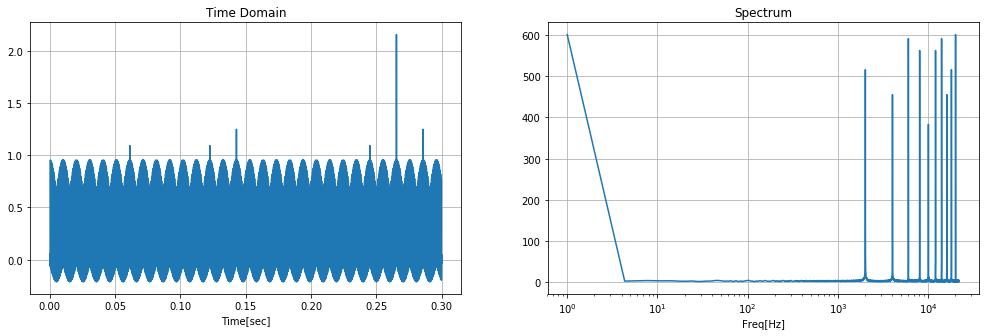

In [127]:
tfPlot(y, fs= fs)

In [128]:
Audio(data=y, rate=fs)

# Sawtooth

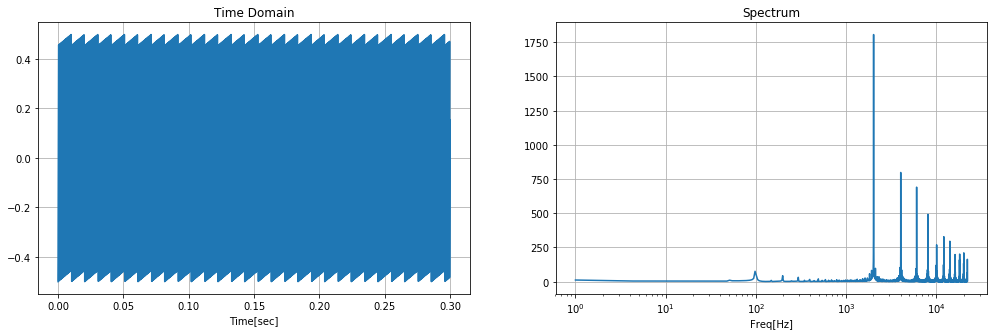

In [139]:
# naive sawtooth
naive_saw = np.zeros(int(N))

for i in range(len(n)):
    naive_saw[i] = (i % P)/P - 0.5
    
tfPlot(naive_saw, fs=fs)    


In [130]:
Audio(data=naive_saw, rate=fs)

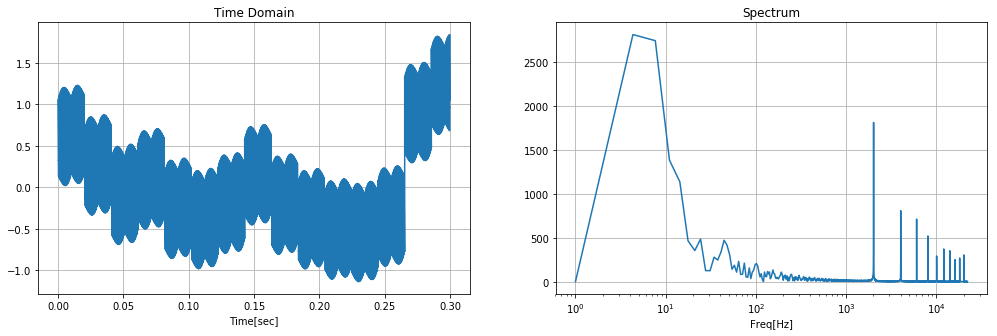

In [140]:
avg = np.average(y) #get DC component of BLIT
saw = np.cumsum(y-avg) # integrate after removing the dc component
saw -= np.average(saw) #remove DC component of result

tfPlot(saw, fs=fs)

In [132]:
Audio(data=saw, rate=fs)

In [11]:
def sawToothTable(N=4096, M=None, phaseOffset = 0.25):
    """
    Generate a BLIT synthesized Sawtooth table.
    """
    n = np.arange(N)+1+N*phaseOffset
    P = N
    if M== None:
        M = 2*np.floor(P/2.)+1 #Number of Harmonics
    y = sampledSinc(n, M, P) #sinc signal
    
    avg = np.average(y) #get DC component of BLIT
    saw = np.cumsum(y-avg) # integrate after removing the dc component
    saw -= np.average(saw) #remove DC component of result
    
    return saw

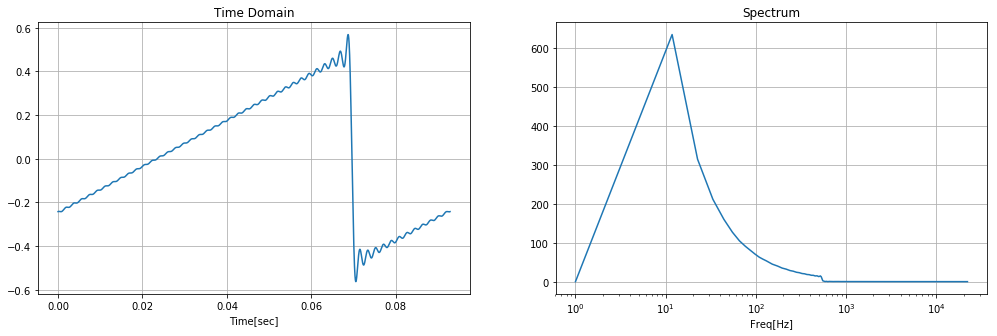

In [12]:
sawTable = sawToothTable(M=100)
tfPlot(sawTable, fs=fs)

# Realtime Capable Sawtooth

For the realtime Sawtooth the DC component is approximated via an IIR filter and the integration is done via a Leaky integrator (one pole). 


## Leaky Integrator 

$$ H(z) = \frac{1}{1 -z^{-1}\alpha}$$

where $\alpha$ is very close to 1.

This basically means
$$ y(n) = x(n)+y(n-1)\alpha $$



In [26]:
def leakyIntegrator(x, alpha=1-10e-6):
    return signal.lfilter([1.0, 0.], [1., -alpha], x)    

In [27]:
def leakyIntegratorPython(x, alpha=1-10e-6):
    """
    This just demaonstrates what happens inside the much more efficient scipy version.
    """
    Y = np.zeros_like(x)
    y1 = 0
    for i in range(len(x)):
        y = x[i]*1+y1*alpha
        y1=y
        Y[i]=y
    return Y

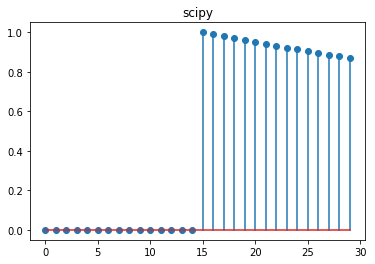

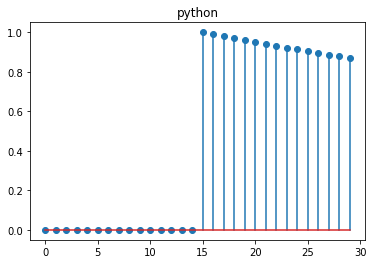

In [28]:
N = 30
alpha = 0.99
testIn = signal.unit_impulse(N, int(N/2))
testOut = leakyIntegrator(testIn, alpha=alpha)
testOutP = leakyIntegratorPython(testIn, alpha=alpha)

plt.stem(np.arange(N),testOut)
plt.title('scipy')
plt.show()
plt.stem(np.arange(N),testOutP)
plt.title('python')
plt.show()

## Plot of Different $\alpha$ Coefficiants

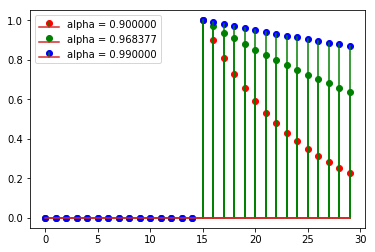

In [29]:
colors = ['ro', 'go', 'bo']
for i in range(3):
    alpha = 1-10**-(i*0.5+1)
    Y = leakyIntegrator(testIn, alpha=alpha)
    plt.stem(np.arange(N),Y, 'g',label= 'alpha = %f' % alpha, markerfmt=colors[i])
plt.legend(loc='best')
plt.show()

In [30]:
def runningAvg(x, alpha=0.995):
    """
    IIR aproximation of a running average
    """
    return signal.lfilter([1-alpha,0],[1,-alpha],x)

Having all that, we still use the BLIT from above as $y$:

0.009812917387371932


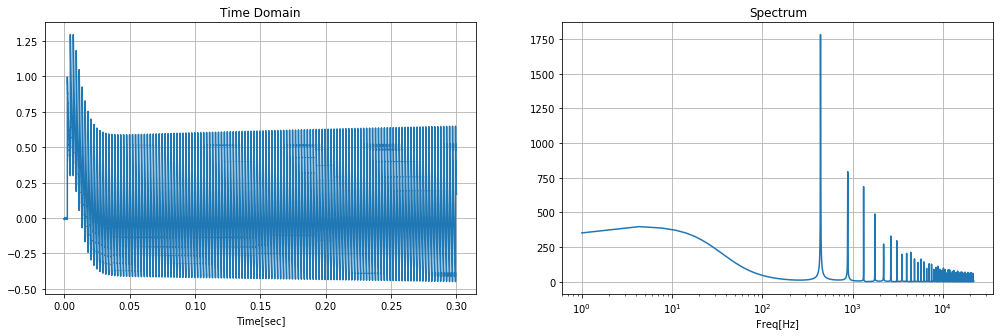

In [31]:
newAvg = runningAvg(y) #get DC component of BLIT
print(np.average(newAvg))
saw = leakyIntegrator(y-newAvg) # integrate after removing the dc component
saw -= runningAvg(saw) #remove DC component of result

tfPlot(saw, fs=fs)

In [32]:
Audio(data=saw, rate=fs)

## Sweep

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


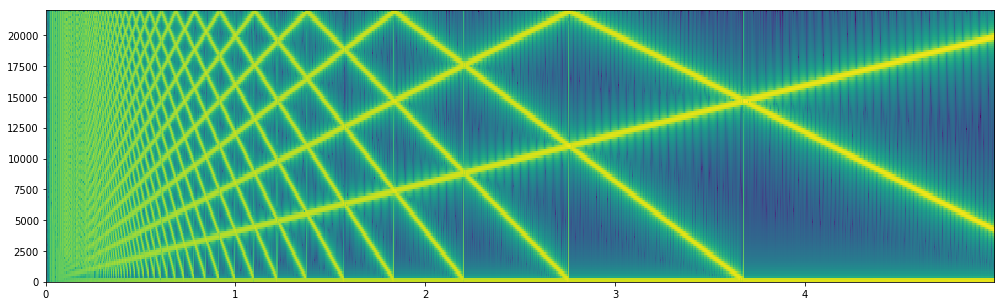

In [39]:
T = 5 #sec
fs = 44100. #Hz
N = int(T*fs) #num Samples
n = np.arange(N)+1 #sample Index
t = n/fs #time
freqSweep = np.linspace(20, 10000, N)

Y = np.zeros_like(t)


for i in range(N):
    freq = freqSweep[i] #Hz
    T1 = 1./freq #period in Seconds
    Ts = 1./fs #sampling Period
    P = T1/Ts # (1/freq)*fs
    M = 2*np.floor(P/2.)+1 #Number of Harmonics
    y = sampledSinc(i, M, P)
    Y[i]=y

plt.figure(figsize=[17,5])
plt.specgram(Y, Fs=fs)
plt.show()
    

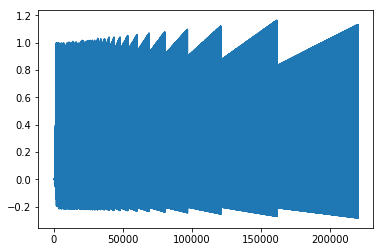

In [34]:
plt.plot(Y)
plt.show()

In [35]:
Audio(data=Y, rate=fs)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## References
https://ccrma.stanford.edu/~stilti/papers/blit.pdf    
https://ccrma.stanford.edu/~jos/fp/One_Pole.html